# Deep RL Assignment 1: Imitation Learning
# CS294-11, UC Berkeley

## Behavioral cloning

Rollouts were generated at ```../expert_data/``` running the bash file ```../demo.bash```.

Behavioral cloning was implemented at ```../behavioral_cloning.py```. The policies were generated running the bash file ```../behavioral_cloning.bash```, and the policies were saved at ```../behavioral_cloning/```.

In [1]:
import behavioral_cloning
import pandas as pd


  TensorFlow's `tf-nightly` package will soon be updated to TensorFlow 2.0.

  Please upgrade your code to TensorFlow 2.0:
    * https://www.tensorflow.org/beta/guide/migration_guide

  Or install the latest stable TensorFlow 1.X release:
    * `pip install -U "tensorflow==1.*"`

  Otherwise your code may be broken by the change.

  


Using TensorFlow backend.


Ant-v2 is a good agent for behavioral cloning. ```render```is set to ```False``` because mujoco-py screen doesn't close after running.

In [2]:
bc_returns_1, bc_mean_1, bc_std_1 = behavioral_cloning.main(envname="Ant-v2", render=False, num_rollouts=20)


Instructions for updating:
Please use tf.global_variables instead.
Instructions for updating:
Use `tf.variables_initializer` instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/home/lucasresck/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
iter 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 2
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 3
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 4
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 5
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 6
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 7
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
iter 8
100/1000
20

Hopper-v2 isn't a good agent for behavioral cloning.

In [3]:
bc_returns_2, bc_mean_2, bc_std_2 = behavioral_cloning.main(envname="Hopper-v2", render=False, num_rollouts=20)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
iter 0
100/1000
200/1000
iter 1
100/1000
200/1000
iter 2
100/1000
200/1000
iter 3
100/1000
200/1000
iter 4
100/1000
200/1000
iter 5
100/1000
200/1000
iter 6
100/1000
200/1000
iter 7
100/1000
200/1000
iter 8
100/1000
200/1000
iter 9
100/1000
200/1000
iter 10
100/1000
200/1000
iter 11
100/1000
200/1000
iter 12
100/1000
200/1000
iter 13
100/1000
200/1000
iter 14
100/1000
200/1000
iter 15
100/1000
200/1000
iter 16
100/1000
200/1000
iter 17
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
iter 18
100/1000
200/1000
iter 19
100/1000
200/1000


Note that Ant-v2 really is better than Hopper in behavioral cloning.

In [4]:
pd.DataFrame({"Ant-v2": [bc_mean_1, bc_std_1], "Hopper-v2": [bc_mean_2, bc_std_2]}, index=["Mean", "Std"])

,Ant-v2,Hopper-v2
Mean,4832.997688,754.747635
Std,103.372787,249.445903


I think the comparison is fair enough, "in terms of network size, amount of data, and number of training iterations". We have here a network of two layers, with 64 neurons in the first one. The amount of data is the data generated from the expert policies. The number of iterations are the same: 20.

The hyperparameter chosen to variate is the number of epochs, and the agent is the Hopper-v2, which didn't perform very well. I will start with 20 epochs and increase 20, until 400 epochs. Let's get the data:

In [5]:
import os
import pickle

os.chdir("../")

with open(os.path.join('expert_data', 'Hopper-v2.pkl'), 'rb') as f:
    expert_data = pickle.load(f)
                              
os.chdir("Report/")

In [6]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense

data = (expert_data['observations'], expert_data['actions'])

y = []

for epochs in range(20, 401, 20):
    print("With " + str(epochs) + " epochs")
    model = Sequential()
    model.add(Dense(units=64, input_shape=(len(data[0][0]),), activation='relu'))
    model.add(Dense(units=len(data[1][0])))
    model.compile(loss='mse', optimizer='adam')
    model.fit(data[0], data[1], batch_size=128, epochs=epochs, verbose=0)
    # print(model.predict(data[0][0][None,:]))
    
    import gym
    env = gym.make("Hopper-v2")
    max_steps = None or env.spec.timestep_limit

    returns = []
    observations = []
    actions = []
    for i in range(5):
        print('iter', i)
        obs = env.reset()
        done = False
        totalr = 0.
        steps = 0
        while not done:
            action = model.predict(obs[None,:])
            observations.append(obs)
            actions.append(action)
            obs, r, done, _ = env.step(action[None,:])
            # print(obs.shape)
            totalr += r
            steps += 1
            # env.render()
            if steps % 100 == 0: print("%i/%i"%(steps, max_steps))
            if steps >= max_steps:
                break
        returns.append(totalr)
    y.append(np.mean(returns))
    print()

With 20 epochs
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
iter 0
iter 1
iter 2
iter 3
iter 4

With 40 epochs
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
iter 0
100/1000
iter 1
100/1000
iter 2
100/1000
iter 3
100/1000
iter 4
100/1000

With 60 epochs
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
iter 0
100/1000
200/1000
300/1000
iter 1
100/1000
200/1000
300/1000
iter 2
100/1000
200/1000
300/1000
iter 3
100/1000
200/1000
300/1000
iter 4
100/1000
200/1000
300/1000

With 80 epochs
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.f

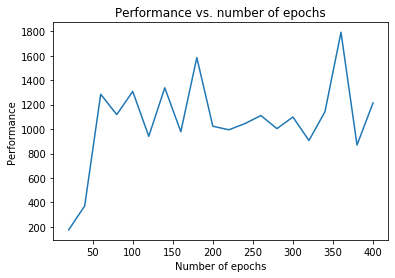

In [12]:
import matplotlib.pyplot as plt

plt.title("Performance vs. number of epochs")
plt.xlabel("Number of epochs")
plt.ylabel("Performance")
plt.plot(np.linspace(20, 400, num=20), y)

## Dagger

Dagger was implemented at ```../dagger.py```. The policies were generated running the bash file ```../dagger.bash```, and the policies were saved at ```../dagger/```.

In [8]:
from dagger import main as dagger

In [9]:
dagger_mean, dagger_std = dagger(expert_policy_file="experts/Hopper-v2.pkl", envname="Hopper-v2", render=True, num_rollouts=5)

/home/lucasresck/Repositories/IC/homework/hw1
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built

Dagger iteration 0

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
iter 0


/home/lucasresck/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


100/1000
200/1000
iter 1
100/1000
200/1000
iter 2
100/1000
200/1000
iter 3
100/1000
200/1000
iter 4
100/1000
200/1000

Dagger iteration 1

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
iter 0
100/1000
200/1000
iter 1
100/1000
200/1000
iter 2
100/1000
200/1000
iter 3
100/1000
200/1000
iter 4
100/1000
200/1000

Dagger iteration 2

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
iter 0
100/1000
200/1000
300/1000
iter 1
100/1000
200/1000
300/1000
400/1000
iter 2
100/1000
200/1000
300/1000
400/1000
iter 3
100/1000
200/1000
300/1000
400/1000
iter 4
100/1000
200/1000
300/1000
400/1000
500/1000

Dagger iteration 3

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide 

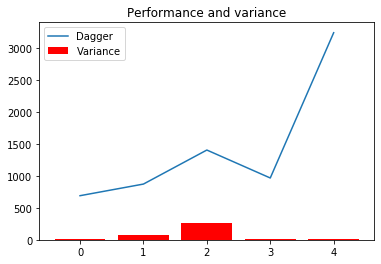

In [25]:
x = np.array(range(len(dagger_mean)))

plt.plot(x, dagger_mean, label="Dagger")
plt.bar(x, dagger_std, color="red", label="Variance")
plt.title("Performance and variance")
plt.legend()
plt.show()